#### Pré processamento

In [ ]:
import re

def limpar_texto_bruto(texto):
    # Dicionário de abreviações comuns
    abreviacoes = {
        "q": "que",
        "pq": "porque",
        "vc": "você",
        "vcs": "vocês",
        "tb": "também",
        "blz": "beleza",
        "hj": "hoje",
        "amanha": "amanhã",
        "mt": "muito",
        "td": "tudo",
        "obg": "obrigado",
        "vlw": "valeu",
        "msg": "mensagem",
        "n": "não",
        "s": "sim"
    }

    # Remove URLs e menções
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"@\w+", "", texto)
    texto = re.sub(r'#', ' ', texto)

    # Substitui abreviações (com bordas de palavras)
    for abrev, exp in abreviacoes.items():
        texto = re.sub(rf'\b{re.escape(abrev)}\b', exp, texto, flags=re.IGNORECASE)

    return texto


In [12]:
import spacy
import nltk
from spacy.matcher import Matcher

nlp = spacy.load('pt_core_news_lg')
stopwords = set(nltk.corpus.stopwords.words('portuguese'))

# Matcher para padrões como "20 mil pessoas" e datas
matcher = Matcher(nlp.vocab)

padrao_cardinal_substantivo = [
    {"LIKE_NUM": True},
    {"LOWER": {"IN": ["mil", "milhão", "milhões", "bilhão", "bilhões"]}, "OP": "?"},
    {"LOWER": "de", "OP": "?"},
    {"POS": "NOUN"}
]
padrao_num_extenso = [
    {"POS": "NUM"},
    {"LOWER": "de", "OP": "?"},
    {"POS": "NOUN"}
]
padrao_ordinal = [
    {"TAG": "ORD"},
    {"LOWER": "de", "OP": "?"},
    {"POS": "NOUN"}
]
matcher.add("NUM_UNIDADE", [padrao_cardinal_substantivo, padrao_num_extenso, padrao_ordinal])


# Verbos principais e auxiliares
padrao_verbo = [{"POS": {"IN": ["VERB"]}}]

# Substantivos comuns
padrao_substantivo = [{"POS": "NOUN"}]

# Substantivos próprios (nomes de pessoas, lugares, marcas etc.)
padrao_proprio = [{"POS": "PROPN"}]

# Adjetivos (qualificações, características)
padrao_adjetivo = [{"POS": "ADJ"}]

# Opcional: advérbios de modo ou intensidade
padrao_adverbio = [{"POS": "ADV"}]

#matcher.add("VERBOS", [padrao_verbo])
matcher.add("SUBSTANTIVOS", [padrao_substantivo])
matcher.add("PROPRIOS", [padrao_proprio])
matcher.add("ADJETIVOS", [padrao_adjetivo])
#matcher.add("ADVERBIOS", [padrao_adverbio])

'''padrao1 = [{'DEP': 'nsubj'}]
padrao2 = [{'DEP': 'ROOT'}]
padrao3 = [{'DEP': 'obj'}]
padrao4 = [{'DEP': 'iobj'}]
padrao5 = [{'DEP': 'nmod'}]
padrao6 = [{'DEP': 'obl'}]
padrao7 = [{'DEP': 'advmod'}]
padrao8 = [{'DEP': 'csubj'}]
padrao9 = [{'DEP': 'ccomp'}]
padrao10 = [{'DEP': 'xcomp'}]
padrao11 = [{'ORTH': '#'}, {'IS_ASCII': True}]
#{'OP':'?','ORTH': '#','IS_ASCII': True}

matcher.add('Regra A',[padrao1])
matcher.add('Regra B',[padrao2])
matcher.add('Regra C',[padrao3])
matcher.add('Regra D',[padrao4])
matcher.add('Regra E',[padrao5])
matcher.add('Regra F',[padrao6])
matcher.add('Regra G',[padrao7])
matcher.add('Regra H',[padrao8])
matcher.add('Regra I',[padrao9])
matcher.add('Regra J',[padrao10])
matcher.add('Regra k',[padrao11])
'''


"padrao1 = [{'DEP': 'nsubj'}]\npadrao2 = [{'DEP': 'ROOT'}]\npadrao3 = [{'DEP': 'obj'}]\npadrao4 = [{'DEP': 'iobj'}]\npadrao5 = [{'DEP': 'nmod'}]\npadrao6 = [{'DEP': 'obl'}]\npadrao7 = [{'DEP': 'advmod'}]\npadrao8 = [{'DEP': 'csubj'}]\npadrao9 = [{'DEP': 'ccomp'}]\npadrao10 = [{'DEP': 'xcomp'}]\npadrao11 = [{'ORTH': '#'}, {'IS_ASCII': True}]\n#{'OP':'?','ORTH': '#','IS_ASCII': True}\n\nmatcher.add('Regra A',[padrao1])\nmatcher.add('Regra B',[padrao2])\nmatcher.add('Regra C',[padrao3])\nmatcher.add('Regra D',[padrao4])\nmatcher.add('Regra E',[padrao5])\nmatcher.add('Regra F',[padrao6])\nmatcher.add('Regra G',[padrao7])\nmatcher.add('Regra H',[padrao8])\nmatcher.add('Regra I',[padrao9])\nmatcher.add('Regra J',[padrao10])\nmatcher.add('Regra k',[padrao11])\n"

In [19]:
from spacy.util import filter_spans

def pre_processamento_ent_numeros(texto):
    texto = limpar_texto_bruto(texto)
    doc = nlp(texto)

    # Identifica spans compostos (ex: "vinte mil pessoas")
    matches = matcher(doc)
    spans = [doc[start:end] for _, start, end in matches]
    spans_filtrados = filter_spans(spans)

    # Mapeia início do span -> span para evitar tokenização duplicada
    spans_dict = {span.start: span for span in spans_filtrados}
    ent_by_start = {ent.start: ent for ent in doc.ents}

    tokens = []
    i = 0
    while i < len(doc):
        if i in ent_by_start: #lida com entidades
            ent = ent_by_start[i]
            ent_text = ent.text
            tokens.append(ent_text)
            i = ent.end
        elif i in spans_dict: #lida com matchers
            span = spans_dict[i]
            span_text = span.text.lower()
            if len(span) == 1:
                if span[0].pos_ == "VERB":
                    tokens.append(span[0].lemma_)
                elif span[0].is_alpha:
                    tokens.append(span_text)
            else:
                tokens.append(span_text)
            i = span.end
        else: #demais
            i += 1        

    return tokens


In [ ]:
from enelvo.normaliser import Normaliser
import csv

resultado = [] 
valores = []

with open('datasets/amostra_80_mil.csv', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for line in reader:
      txt = line['description']
      valores.append(txt)
      pre_proc = pre_processamento_ent_numeros(txt)
      resultado.append(pre_proc)
      

In [16]:
print(valores)
print(resultado)

['Not in my name.#vonderLeyen #PfizerGate', 'MT prorroga prazo para vacinação contra bruceloseO prolongamento da data se deve a um déficit de aproximadamente 249 mil doses de vacinas no Estado para essa primeira etapa da campanha, informa o Indeahttps://t.co/9yW900ecIt', '@AndreGA_Pe O Crispr/Cas9 é uma espécie de "tesoura genética", que permite mudar parte do código genético de uma célula, é possível, por exemplo, "cortar" uma parte do DNA, de modo que a célula produza ou não determinadas proteínas.É uma técnica de engenharia genética, não é a vacina.', '@licamedeiros espero que alguma das vacinas nasais funcione pra bloquear a infecção e chegue até nós 😭', '@lucascentrismo “homem” com a boca desenhadinha 💅', 'Covid 10/06: 56.941 novos casos, 170 óbitos, totalizando 31.417.341 casos e 667.960 óbitos; Fonte ConassEm 10 dias de junho são 1284 óbitos, aumento de 391 óbitos relação a maio e queda em relação a abril de 217Junho tem 398.303 casos, com média de óbitos 128#VacinaSalva https:/

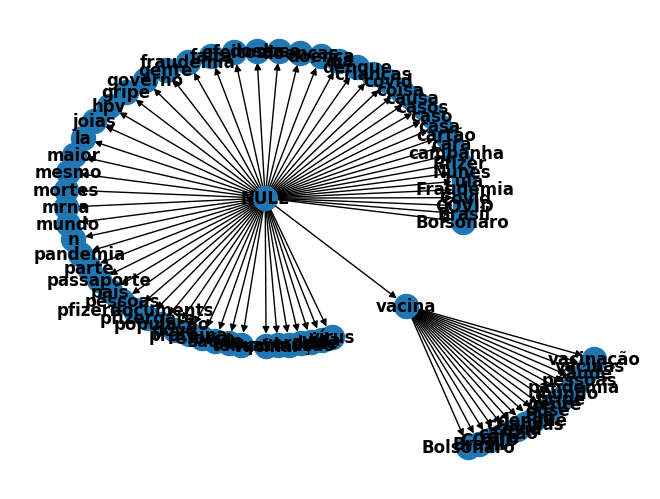

In [16]:
from trieofrules import trieofrules

#supported algorithms: FP-max, FP-growth, Apriori
TOR = trieofrules(data = resultado, alg='Apriori', min_support=0.01) 
TOR.draw()
TOR.save_graph(filename = 'outputs/vacinal_twitter.graphml') 

In [6]:
#print('Sequências frequentes:')
#for i in TOR.frequent_sequences:
#    print(i)

print('\nTermos frequentes:')
for i in TOR.frequent_items:
    print(i)


Termos frequentes:
Bolsonaro
Brasil
COVID
Pfizer
Covid
Fraudemia
Nunes
Lula
PF
VacinaSalva
